In [ ]:
!pip install scanpy

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [ ]:
#need to install these too
!conda install -y -c anaconda cmake 
!pip install leidenalg
!pip install louvain

In [ ]:
#easy to follow tutorial on scanpy readthedocs
#https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [5]:
#tutorial_sample was the dir created by cellranger based on our flag: --id tutorial_sample

adata = sc.read_10x_mtx(
    'tutorial_sample/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [6]:
adata

AnnData object with n_obs × n_vars = 8845 × 36602
    var: 'gene_ids', 'feature_types'

# Preprocessing

In [7]:
sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells

In [10]:
#IF YOU ARE DOING MOUSE YOU MIGHT NEED TO CHANGE MT- to Mt. Always double check you actually labeld MT
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [13]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/jrlab2019/miniconda3/envs/geo/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


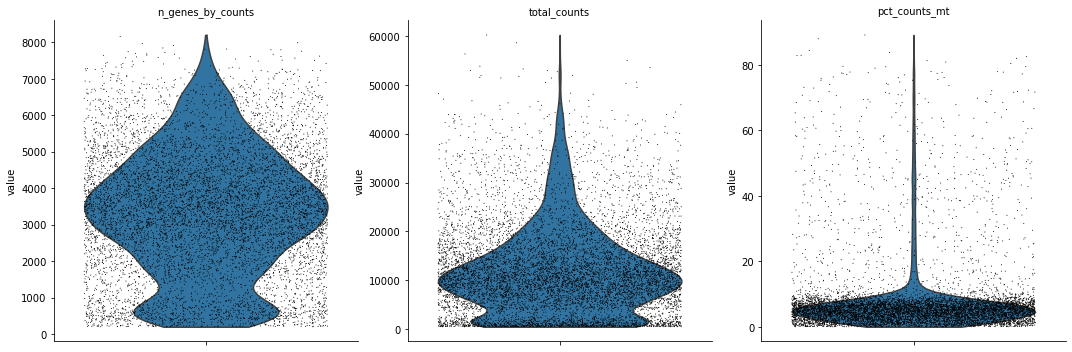

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

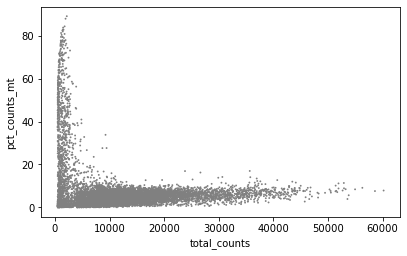

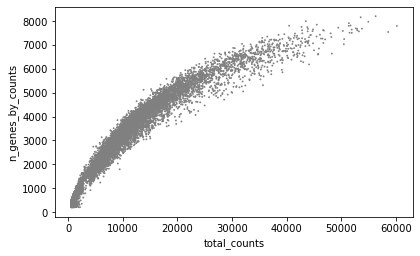

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
#instead of picking subjectively, you can use quanitle
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

320.0 to 6748.32


In [20]:
adata[adata.obs.index == 'AAACCCAAGCCTGTGC-1']

View of AnnData object with n_obs × n_vars = 1 × 21949
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [21]:
#adata = adata[adata.obs.n_genes_by_counts < 7000, :] #example if you wanted to pick a number yourself
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20]

In [25]:
adata.X[1,:].sum()

25977.0

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

/home/jrlab2019/miniconda3/envs/geo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
adata.X[0,:].sum()

9999.969

In [29]:
sc.pp.log1p(adata) #change to log counts

# Clustering

In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values

In [33]:
adata.raw = adata #save raw data before processing values and further filtering

In [34]:
adata = adata[:, adata.var.highly_variable] #filter highly variable

In [38]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

In [39]:
sc.pp.scale(adata, max_value=10) #scale each gene to unit variance

In [42]:
sc.tl.pca(adata, svd_solver='arpack')

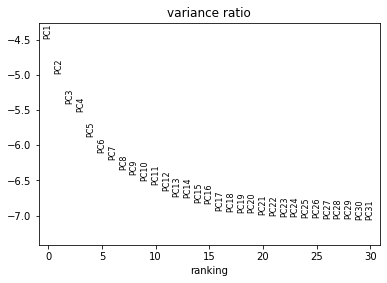

In [43]:
sc.pl.pca_variance_ratio(adata, log=True)

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

2022-01-30 20:12:44.898084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-30 20:12:44.898108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [45]:
sc.tl.umap(adata)

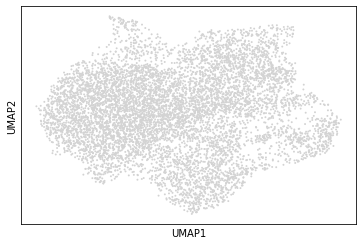

In [46]:
sc.pl.umap(adata)

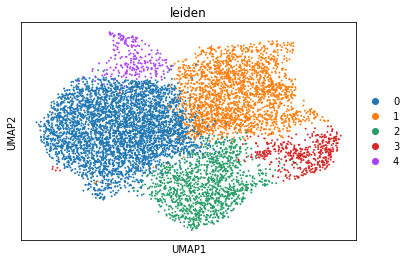

In [48]:
sc.tl.leiden(adata, resolution = 0.25)
sc.pl.umap(adata, color=['leiden'])

# Find markers

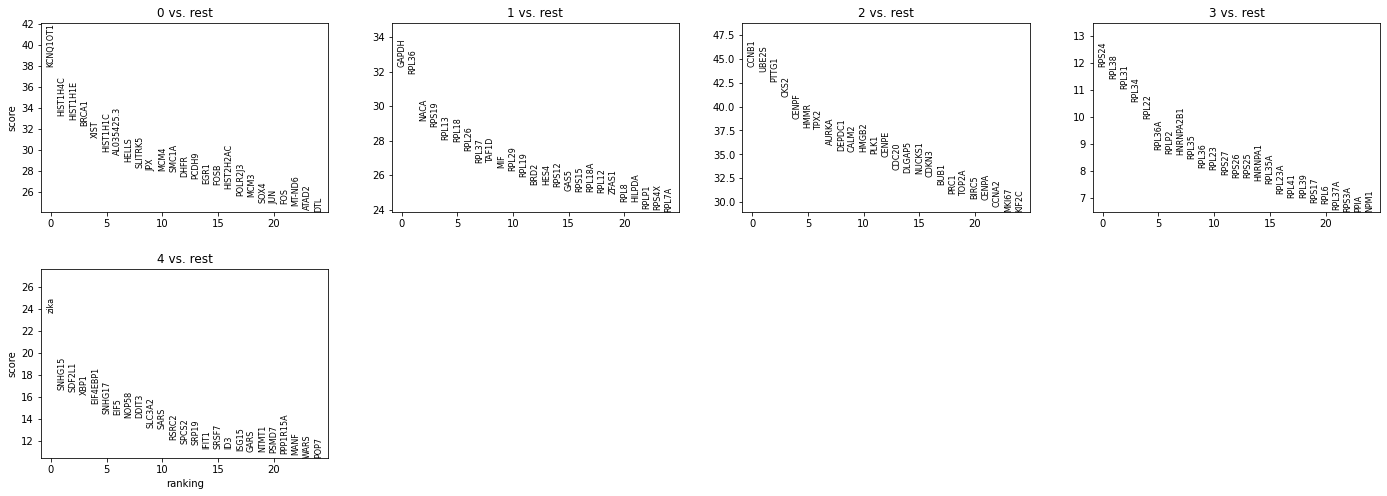

In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

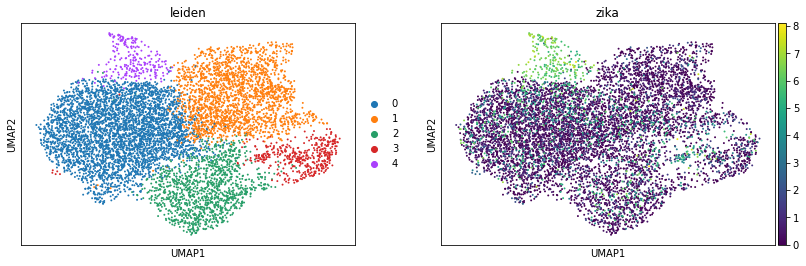

In [50]:
sc.pl.umap(adata, color=['leiden', 'zika'])

In [55]:
results = adata.uns['rank_genes_groups']

In [56]:
results['names']['0']

array(['KCNQ1OT1', 'HIST1H4C', 'HIST1H1E', ..., 'LDHA', 'CKS2', 'RPL36'],
      dtype=object)

In [57]:
results['names'].dtype.names

('0', '1', '2', '3', '4')

In [58]:
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))

In [60]:
out.shape

(109746, 5)

In [62]:
markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

In [65]:
markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]

In [67]:
markers[markers.cluster == '4']

,Gene,scores,pval_adj,lfc,cluster
87796,zika,23.704487,0.0,8.062958,4
87797,SNHG15,16.631556,0.0,1.818314,4
87798,SDF2L1,16.453564,0.0,1.920571,4
87799,XBP1,16.216284,0.0,1.708001,4
87800,EIF4EBP1,15.350019,0.0,1.237626,4
...,...,...,...,...,...
109739,SOX4,-13.782868,0.0,-1.743386,4
109740,PGK1,-13.823959,0.0,-1.340903,4
109741,MSMO1,-13.977442,0.0,-2.380198,4
109743,SLC25A3,-16.256285,0.0,-1.478398,4


In [68]:
adata.raw.var_names

Index(['AL627309.1', 'AL627309.5', 'LINC01409', 'FAM87B', 'LINC01128',
       'LINC00115', 'FAM41C', 'AL645608.2', 'AL645608.4', 'LINC02593',
       ...
       'MT-CYB', 'BX004987.1', 'AC145212.1', 'MAFIP', 'AC011043.1',
       'AL354822.1', 'AL592183.1', 'AC240274.1', 'AC007325.4', 'zika'],
      dtype='object', length=21949)

In [71]:
zik_i = np.where(adata.raw.var_names == 'zika')[0][0]
zik_i

21948

In [76]:
zik = adata.raw.X.toarray()[:,zik_i]

In [78]:
adata.obs['zika'] = zik

In [83]:
adata.obs['Zika'] = zik

In [80]:
adata.obs[adata.obs.zika > 0 ]

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,zika
AAACCCAAGTATAGAC-1,5443,5443,25977.0,1477.0,5.685799,1,0.325668
AAACCCACAACGCATT-1,5159,5159,21172.0,1035.0,4.888532,2,0.386841
AAACCCACACGCGCAT-1,5991,5991,26725.0,1724.0,6.450889,2,5.798806
AAACCCAGTGCATTAC-1,4657,4656,17707.0,678.0,3.828994,2,0.755886
AAACCCAGTTACGCCG-1,3704,3704,11699.0,539.0,4.607232,0,0.617763
...,...,...,...,...,...,...,...
TTTGGTTCACCATAAC-1,3452,3450,11069.0,668.0,6.034873,0,1.032062
TTTGTTGAGATCCGAG-1,4330,4330,16295.0,378.0,2.319730,0,0.478521
TTTGTTGAGGCACAAC-1,5052,5051,17574.0,891.0,5.069990,2,0.450453
TTTGTTGAGTCACACT-1,3281,3281,9758.0,370.0,3.791761,0,0.705471


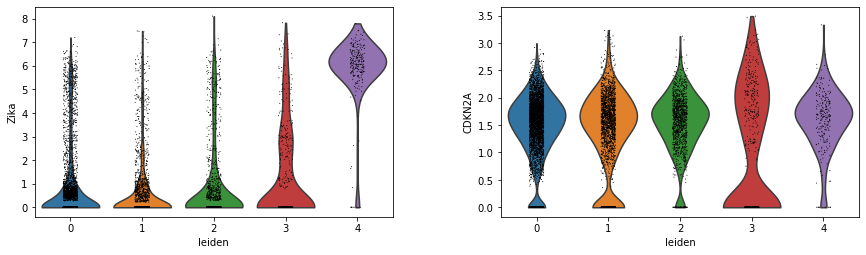

In [86]:
sc.pl.violin(adata, ['Zika', 'CDKN2A'], groupby='leiden', use_raw = True)